<!--NOTEBOOK_HEADER-->
*This notebook contains material from the [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by 
Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Financial Applications](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.00-Financial-Applications.ipynb) | [Contents](toc.ipynb) | [Historical Stock Data](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.02-Historical-Stock_-ata.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.01-Binomial-Model-for-Pricing-Options.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Binomial Model for Pricing Options

This notebooks demonstrates techniques for pricing options using a binomial lattice to model prices of the underlying security or commodity. The notebook makes use of the pandas_datareader library to download pricing information, and the Pyomo modeling library for some example calculations.

In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils

## Historical data

The first step is download historical data for a selected security or commodity.  For the purposes of this notebook, it is useful to choose security of commodities for which there is an active options trading so the pricing model can be compared to real data.


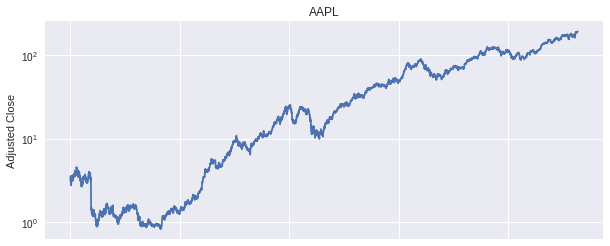

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

!wget -N -q "https://raw.githubusercontent.com/jckantor/ND-Pyomo-Cookbook/master/notebooks/finance/Historical_Adjusted_Close.csv"
S_hist = pd.read_csv('/content/Historical_Adjusted_Close.csv', index_col=0)

S_hist['AAPL'].plot(title='AAPL', logy=True)
plt.ylabel('Adjusted Close')
plt.grid(True)

### Trim data series

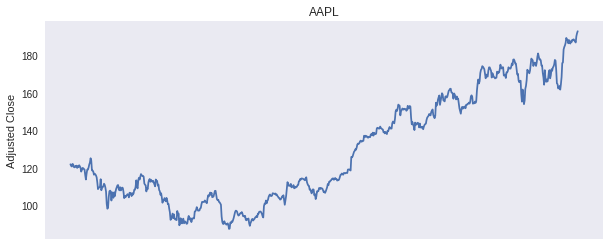

In [6]:
nYears = 3

S = S_hist['AAPL'].iloc[-nYears*252:]

plt.figure(figsize=(10,4))
S.plot(title=S.name)
plt.ylabel('Adjusted Close')
plt.grid(True)

# Fitting historical data to geometric Brownian motion

A model for Geometric Brownian Motion can be written in discrete time as

$$S_{t + \Delta t} = S_t + \mu S_t \Delta t + \sigma S_t \sqrt{\Delta t} Z_t $$

where $Z_t$ is a normal random variate with zero mean and a standard deviation of one. This could also be written as 

$$ \ln S_{t + \Delta t} = \ln S_t + \nu \Delta t + \sigma \sqrt{\Delta t} Z_t $$

where $\nu = \mu -\frac{\sigma^2}{2}$. These are two different models for price. The difference between $\mu$ and $\nu$, i.e.  $\frac{\sigma^2}{2}$, is referred to as 'volatility drag.' 

Rearranging each of these models

\begin{align*}
r^{lin} & = \frac{S_{t+\Delta t} - S_t}{S_t} = \mu\Delta t + \sigma \sqrt{\Delta t}Z_t \sim \cal{N}(\mu\Delta t, \sigma^2\Delta t)\\
r^{log} & = \ln S_{t+\Delta t} - \ln S_t = \nu\Delta t + \sigma \sqrt{\Delta t}Z_t \sim \cal{N}(\nu\Delta t,\sigma^2\Delta t)\\
\end{align*}

where $\cal{N}(\alpha,\beta)$ denotes the normal distribution with mean $\alpha$ and variance $\beta$ (i.e., standard deviation $\sqrt{\beta}$).

The parameters can be estimated from trading data as

\begin{align*}
\hat{\mu} & = \frac{1}{\Delta t} \mbox{mean}(\frac{S_{t+\Delta t} - S_t}{S_t}) \\
\hat{\nu} & = \frac{1}{\Delta t} \mbox{mean}(\ln S_{t+\Delta t} - \ln S_t) \\
\hat{\sigma} & = \frac{1}{\sqrt{\Delta t}} \mbox{stdev}(\frac{S_{t+\Delta t} - S_t}{S_t}) \approx  \frac{1}{\sqrt{\Delta t}} \mbox{stdev}(\ln S_{t+\Delta t} - \ln S_t)
\end{align*}


Note that for trading data time is measured in 'trading days'. On average there are 252 trading days in a year.

| Period | Trading Days |
| :----: | :----------: |
| Year | 252 |
| Quarter | 63 |
| Month | 21 |
| Weekly | 4.83 |
| Calendar Day | 0.690 |

Using these data and the above formulae, $\mu$, $\nu$, and $\sigma$ can be rescaled to other units of time. For example, if these are estimated from daily trading data, then on an annualized basis

\begin{align*}
\mu^{annual} & = 252 \times \mu^{trading\ day} \\
\nu^{annual} & = 252 \times \nu^{trading\ day} \\
\sigma^{annual} & = \sqrt{252} \times \sigma^{trading\ day} \\
\end{align*}


Linear Returns
   mu =   0.00071428  (annualized = 18.00%)
sigma =   0.01450301  (annualized = 23.02%)

Log Returns
   nu =   0.00060890  (annualized = 15.34%)
sigma =   0.01450420  (annualized = 23.02%)


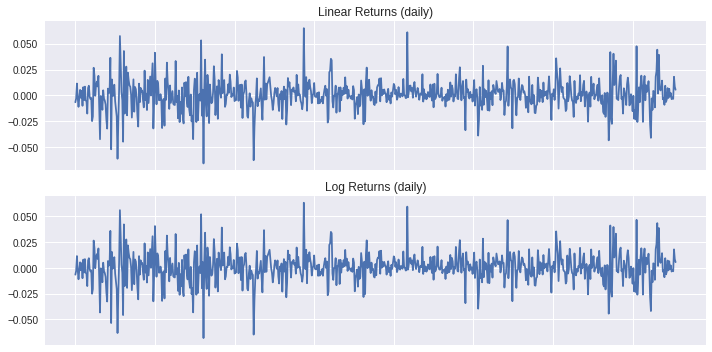

In [8]:
from scipy.stats import norm
import numpy as np

# compute linear and log returns
rlin = (S - S.shift(1))/S.shift(1)
rlog = np.log(S/S.shift(1))

rlin = rlin.dropna()
rlog = rlog.dropna()

# plot data
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
rlin.plot()
plt.title('Linear Returns (daily)')
plt.tight_layout()

plt.subplot(2,1,2)
rlog.plot()
plt.title('Log Returns (daily)')
plt.tight_layout()

print('\nLinear Returns')
mu,sigma = norm.fit(rlin)
print('   mu = {0:12.8f}  (annualized = {1:.2f}%)'.format(mu,100*252*mu))
print('sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))

print('\nLog Returns')
nu,sigma = norm.fit(rlog)
print('   nu = {0:12.8f}  (annualized = {1:.2f}%)'.format(nu,100*252*nu))
print('sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))

## Binomial model

The binomial model provides a means of modeling the statistical distribution of future prices. Given a current price $S_t$, there are two possible states for the next observed value $S_{t+\Delta t}$

$$S_{t + \Delta t} = \begin{cases} u S_t & \mbox{with probability } p \\ d S_t & \mbox{with probability } 1-p\end{cases}$$

where $u$, $d$, and $p$ are chosen to match the statistics of a model based on Geometric Brownian Motion. 
The following parameter values are derived in [Luenberger (2013)](https://global.oup.com/ushe/product/investment-science-9780199740086?cc=us&lang=en&),

\begin{align*}
p & = \frac{1}{2} + \frac{\nu\Delta t}{2\sqrt{\sigma^2\Delta t + (\nu\Delta t)^2}} \\
\ln u & = \sqrt{\sigma^2\Delta t + (\nu\Delta t)^2} \\
\ln d & = - \sqrt{\sigma^2\Delta t + (\nu\Delta t)^2} 
\end{align*}

In [9]:
# Time/period
dt = 21

p = 0.5 + nu*dt/2/np.sqrt(dt*sigma**2 + (nu*dt)**2)
u = np.exp(np.sqrt(dt*sigma**2 + (nu*dt)**2))
d = np.exp(-np.sqrt(dt*sigma**2 + (nu*dt)**2))

print('Probability (p) = ', round(p,4))
print('  Up Return (u) = ', round(u,4))
print('Down Return (d) = ', round(d,4))

Probability (p) =  0.5945
  Up Return (u) =  1.07
Down Return (d) =  0.9346


The model extends to multiple time steps in a natural way as shown in this diagram:

![BinomialModel.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/BinomialModel.png?raw=1)

Note that each step forward in time introduces an additional state to the set of possible outcomes.

For the purpose of coding, we will use Python dictionaries to store future prices $S^f$. Future prices are indexed by two subscripts, $k$ and $s$, such that ``Sf[k,s]`` corresponds to the price at time $t + k\Delta t$ in state $s$.

We start by setting the initial node equal to the last observed price, $S^f_{0,0} = S_t$. For each $k$ and $s$ there are two subsequent nodes

\begin{align*}
S^f_{k + 1, s} & = u S^f_{k,s} \\
S^f_{k + 1, s + 1} & = d S^f_{k,s}
\end{align*}

These two equations can be combined by eliminating the common term $S^f_{k,s}$ to yield

\begin{align*}
S^f_{k + 1, s} & = u S^f_{k,s} \\
S^f_{k+1,s+1} & = \frac{d}{u} S^f_{k+1,s}
\end{align*}

These formula can be solved explicit to give

$$S^f_{k,s} = u^{k-s}d^{s}S^f_{0,0}$$

which is the formula used below to compute values in the binomial lattice.

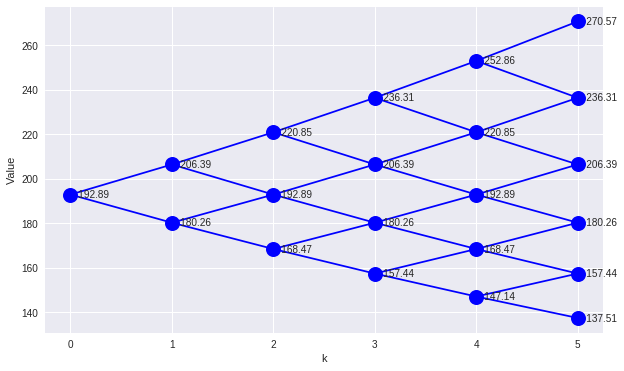

In [11]:
N = 5

# initialize Sf
Sf = {}
Sf[0,0] = S[-1]

# compute values
for k in range(1,N+1):
    for s in range(0,k+1):
        Sf[k,s] = u**(k-s)*d**s*Sf[0,0]
      
%matplotlib inline
def Sdisplay(Sf):
    plt.figure(figsize=(10,6))
    for k,s in Sf.keys():
        plt.plot(k,Sf[k,s],'.',ms=30,color='b')
        plt.text(k,Sf[k,s],'   {0:.2f}'.format(Sf[k,s]),ha='left',va='center')
        if (k > 0) & (s < k):
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s]],'b')
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s+1]],'b')
    plt.xlabel('k')
    plt.ylabel('Value')
    
Sdisplay(Sf)

The probability of reaching state $s$ at time step $k$ is denoted by $P_{k,s}$. This can be computed given probability of preceding states and the conditional probabilities $p$ and $1-p$.

\begin{align*}
P_{k,s} & = p P_{k-1,s} + (1-p) P_{k-1,s-1}
\end{align*}

The following cell evaluates price and probability for a binomial model, and also plot the average price.

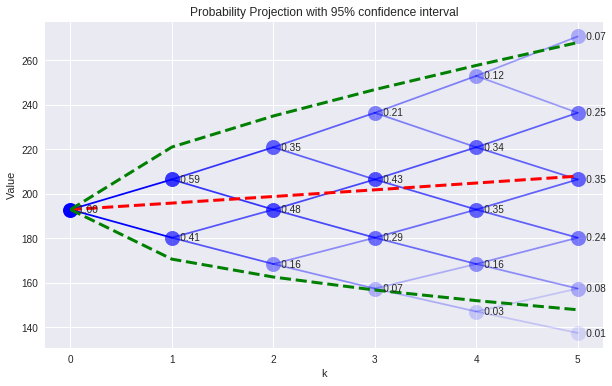

In [13]:
P = {}
P[0,0] = 1

for k in range(0,N):
    P[k+1,0] = p*P[k,0]
    P[k+1,k+1] = (1-p)*P[k,k]
    for s in range(1,k+1):
        P[k+1,s] = p*P[k,s] + (1-p)*P[k,s-1]

%matplotlib inline
def SPdisplay(Sf,P,D):
    plt.figure(figsize=(10,6))
    nPeriods = max([k for k,s in Sf.keys()]) + 1
    Sfmean = np.zeros(N+1)
    Sfvar = np.zeros(N+1)
    for k,s in Sf.keys():
        Sfmean[k] += Sf[k,s]*P[k,s]
        Sfvar[k] += Sf[k,s]**2*P[k,s]
        plt.plot(k,Sf[k,s],'.',ms=30,color='b',alpha=np.sqrt(P[k,s]))
        if (k > 0) & (s < k):
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s]],'b',alpha=np.sqrt(P[k-1,s]))
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s+1]],'b',alpha=np.sqrt(P[k-1,s]))
    for k,s in D.keys():
        plt.text(k,Sf[k,s],'   {0:.2f}'.format(D[k,s]),ha='left',va='center')
    plt.plot(range(0,N+1),Sfmean,'r--',lw=3)
    Sfstdev = np.sqrt(Sfvar - Sfmean**2)
    plt.plot(range(0,N+1),Sfmean + 1.96*Sfstdev,'g--',lw=3)
    plt.plot(range(0,N+1),Sfmean - 1.96*Sfstdev,'g--',lw=3)
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.title('Probability Projection with 95% confidence interval')
SPdisplay(Sf,P,P)


## European call option

A European Call Option is a contract the provides the holder with the right, but not the obligation, to purchase an asset at a specified price and date in the future. The specified price is generally called the **strike price**, and the specified date is the **expiration date**. 

The purpose of the call option is to reduce the holder's exposure to the risk of increasing prices. An airline, for example, might choose to purchase call options on airplance fuels in order to reduce the risk of selling advance tickets.

The value of the call option upon expiration depends on the price of underlying asset. If the asset spot price $S$ is greater than the strike price $K$, then the call option is worth the difference $S-K$ because that is amount needed to fulfill the contract in the spot market. 

On the other hand, if the asset price falls below the strike price, then the option contract has no value since the holder could buy the asset on the spot market for less than the strike price.

$$C_{N,s} = \max(0, S^f_{N,s})$$

The next cell demonstrates the terminal value of a european call option where the strike price is equal to the initial price (known as an 'at the money' strike).

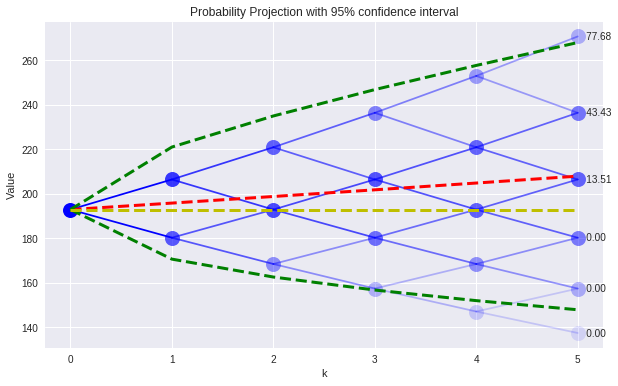

In [14]:
K = S[-1]
C = {}
for s in range(0,N+1):
    C[N,s] = max(0,Sf[N,s] - K)

SPdisplay(Sf,P,C)
plt.plot([0,N],[K,K],'y--',lw=3)

To price a call option, consider the construction of a portfolio composed of the underlying asset and cash that would have the same payoff. At node $k,s$, the portfolio is given by 

$$C_{k,s} = x_{k,s}S^f_{k,s} + y_{k,s}$$

where $x_{k,s}$ is the number of units of the underlying asset, and $y_{k,s}$ is the cash component of the portfolio. The subsequent value of the portfolio at $k+1$ has two possible values

\begin{align*}
C_{k+1,s} & = x_{k,s}uS^f_{k,s} + (1+r)y_{k,s} \\
C_{k+1,s+1} & = x_{k,s}dS^f_{k,s} + (1+r)y_{k,s}
\end{align*}

where $r$ is the per period interest rate for cash. Solving for $x_{k,s}$ and $y_{k,s}$,

\begin{align*}
x_{k,s} & = \frac{C_{k+1,s} - C_{k+1,s+1}}{(u-d)S^f_{k,s}} \\
y_{k,s} & = \frac{uC_{k+1,s+1}-dC_{k+1,s}}{(1+r)(u-d)}
\end{align*}

Inserting these solutions into the original expression,

$$C_{k,s} = \frac{(\left[(1+r) - d\right]C_{k+1,s} + \left[u - (1+r)\right]C_{k+1,s+1}}{(1+r)(u-d)}$$

This can be expressed in a far more suggestive form

$$C_{k,s} = \frac{1}{1+r}\left[\underbrace{\frac{(1+r)-d}{u-d}}_{q}C_{k+1,s} + \underbrace{\frac{u-(1+r)}{u-d}}_{1-q}C_{k+1,s+1}\right]$$

or

$$C_{k,s} = \frac{1}{1+r}\left[q C_{k+1,s} + (1-q)C_{k+1,s+1}\right]$$

This expression has two important consequences. The first is an interpretation as a 'risk-neutral' probability such that $C_{k,s}$ is the 'expected value' of the call option. This is not the real-world probability! Instead, it is different measure that provides a very useful means of computing the value of options as illustrated in the following diagram.

![BinomialModel_Options.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/BinomialModel_Options.png?raw=1)

The second important consequence is the actual pricing formula. It's linear, for one thing, is easily implemented as a calculation that proceeds backward in time as shown in the diagram above. As can be seen from the derivation, the computation is quite general and can be applied to any option which can be assigned a terminal value.

q =  0.5015387932713019


Text(0.5,1,'Cash Position')

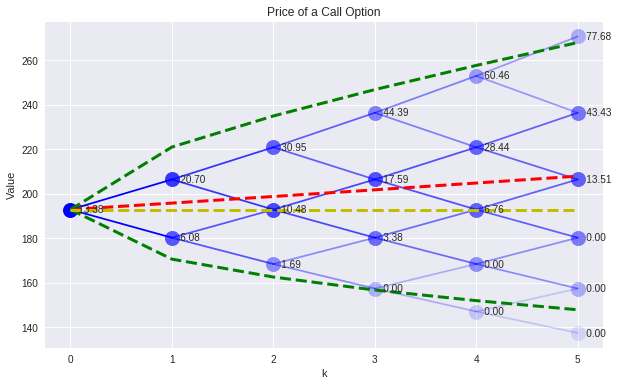

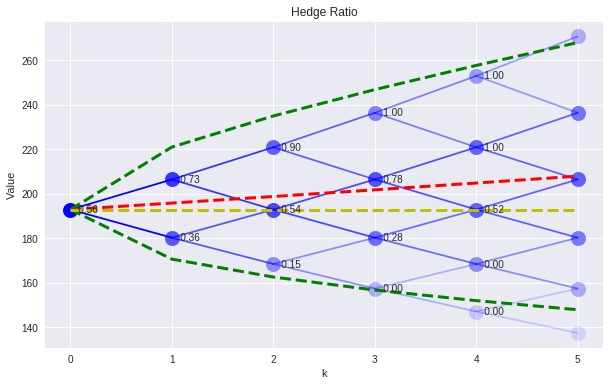

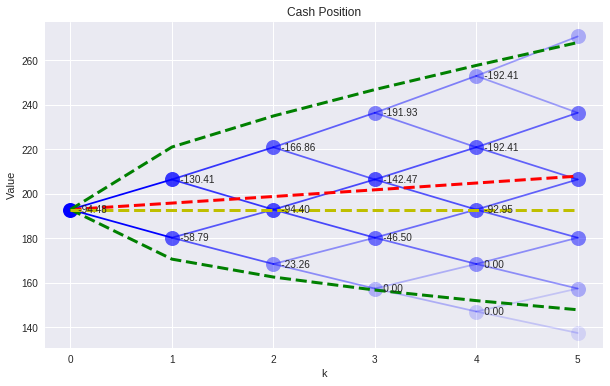

In [15]:
r = 0.030/12
q = (1+r-d)/(u-d)
print('q = ',q)

C = {}
x = {}
y = {}

for s in range(0,N+1):
    C[N,s] = max(0,Sf[N,s] - K)

for k in reversed(range(0,N)):
    for s in range(0,k+1):
        C[k,s] = (q*C[k+1,s]+(1-q)*C[k+1,s+1])/(1+r)
        x[k,s] = (C[k+1,s]-C[k+1,s+1])/(u-d)/Sf[k,s]
        y[k,s] = C[k,s] - x[k,s]*Sf[k,s]

SPdisplay(Sf,P,C)
plt.plot([0,N],[K,K],'y--',lw=3)
plt.title('Price of a Call Option')

SPdisplay(Sf,P,x)
plt.plot([0,N],[K,K],'y--',lw=3)
plt.title('Hedge Ratio')

SPdisplay(Sf,P,y)
plt.plot([0,N],[K,K],'y--',lw=3)
plt.title('Cash Position')

## Implementing a replicating portfolio with Pyomo

A replicating portfolio is the key concept that allows use of the binomial model for pricing options. In a nutshell, the value of an option is the money needed to construct a portfolio  exactly replicate the option payoff. 

This concept can be extended to applications involving 'real assets', including processes that convert commodity resources into higher value products. As a first step, let's see how Pyomo can be used to model a replicating portfolio for a European call option.

We start with an expression for the value of the replicating portfolio at time $k$ in state $s$. For the purpose of later generalization, we use the symbol $W$ to denote wealth,

$$W_{k,s} = x_{k,s}S^f_{k,s} + y_{k,s}B_k$$

The portfolio consists of $x_{k,s}$ units of an underlying asset with a price $S^f_{k,s}$ subject to statistical variability, and $y_{k,s}$ units of a 'bond' which has a known future price and therefore depends only on $k$. For example,

$$B_k = (1 + r_f)^k B_0 $$

where $r_f$ is a risk-free interest rate. This is the 'cash' component of the portfolio.

For a European call option we must have enough wealth on-hand to pay off the value of the call option at $k=N$. This requirement can be written as inequalities

$$W_{N,s} \geq \max(0, S^f_{N,s} - K) \qquad \forall s\in{\cal S}_N $$

where ${\cal S}_N$ is the set of possible states at time step $N$. 

At earlier nodes, the value of the portfolio must be sufficient to finance the portfolio as subsequent states. In the binomial model, for each node $(k,s)$ there are two subsequenct states $(k+1,s)$ and $(k+1,s+1)$. This results in two constraints:

\begin{align*}
x_{k,s}S^f_{k+1,s} + y_{k,s}B_{k+1} & \geq W_{k+1,s} \\
x_{k,s}S^f_{k+1,s+1} + y_{k,s}B_{k+1} & \geq W_{k+1,s+1}
\end{align*}

What we seek is the minimum cost portfolio at the initial node, i.e.,

$$\min_{x,y} W_{0,0}$$

subject to the above constraints.

If everything works as expected, the results of this calculation should be the same as those computed using risk-neutral probabilities.

In [ ]:
K = 200

Text(0.5,1,'Value of a European Call Option')

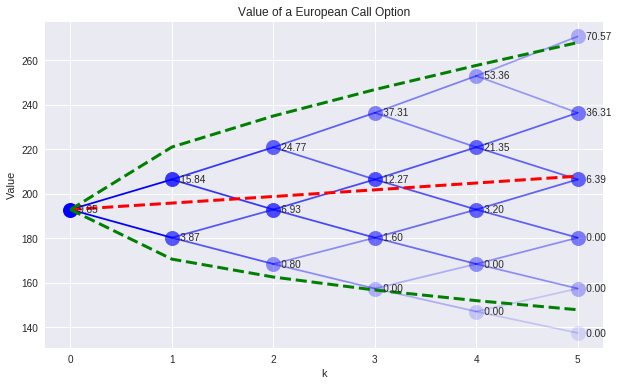

In [17]:
from pyomo.environ import *

# set of periods and states for each period
Periods = range(0,N+1)
States = range(0,N+1)

# future bond prices
B = [(1+r)**k for k in Periods]

m = ConcreteModel()

# model variables
m.W = Var(Periods,States,domain=Reals)
m.x = Var(Periods,States,domain=Reals)
m.y = Var(Periods,States,domain=Reals)

# objective
m.OBJ = Objective(expr = m.W[0,0], sense=minimize)

# constraint list
m.cons = ConstraintList()

for k in Periods:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s]*(1+r)**k)

for s in States:
    m.cons.add(m.W[N,s] >= max(0,Sf[N,s] - K))

for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*Sf[k+1,s] + m.y[k,s]*B[k+1] >= m.W[k+1,s])
        m.cons.add(m.x[k,s]*Sf[k+1,s+1] + m.y[k,s]*B[k+1] >= m.W[k+1,s+1])

SolverFactory('glpk').solve(m)

W = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        W[k,s] = m.W[k,s]()
        
SPdisplay(Sf,P,W)
plt.title('Value of a European Call Option')

## European put option

A European put option is the right (without obligation) to sell an asset for specified price on a specified date. The analysis is proceeds exactly as for the European call option, except that the value on the terminal date is given by

$$P_{N,s} = \max(0, K-S^f_{N,s}) \qquad \forall s\in{\cal S}_N $$

The value of the put option can be computed using the same risk neutral probabilities as for the call option, or by modifying the Pyomo model as shown in the following cell.

Text(0.5,1,'Value of European Put Option')

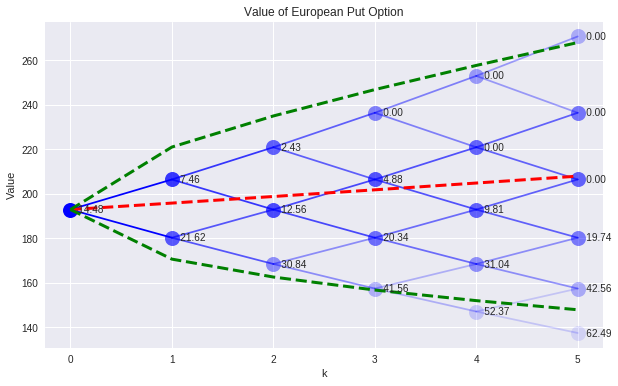

In [18]:
from pyomo.environ import *

# set of periods and states for each period
Periods = range(0,N+1)
States = range(0,N+1)

# future bond prices
B = [(1+r)**k for k in Periods]

m = ConcreteModel()

# model variables
m.W = Var(Periods,States,domain=Reals)
m.x = Var(Periods,States,domain=Reals)
m.y = Var(Periods,States,domain=Reals)

# objective
m.OBJ = Objective(expr = m.W[0,0], sense=minimize)

# constraint list
m.cons = ConstraintList()

for k in Periods:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s]*(1+r)**k)

for s in States:
    m.cons.add(m.W[N,s] >= max(0,K - Sf[N,s]))

for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*Sf[k+1,s] + m.y[k,s]*B[k+1] >= m.W[k+1,s])
        m.cons.add(m.x[k,s]*Sf[k+1,s+1] + m.y[k,s]*B[k+1] >= m.W[k+1,s+1])

SolverFactory('glpk').solve(m)

W = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        W[k,s] = m.W[k,s]()
        
SPdisplay(Sf,P,W)
plt.title('Value of European Put Option')

## Early exercise

Let's compare the value of the put option to the value of exercising the option. At any node $(k,s)$, the value of exercising the option is $K-S^f_{k,s}$. The next cell compares the value of the European put option to hypothetical value of early exercise.

Text(0.5,1,'The hypothetical value of early exercise of European Put Option')

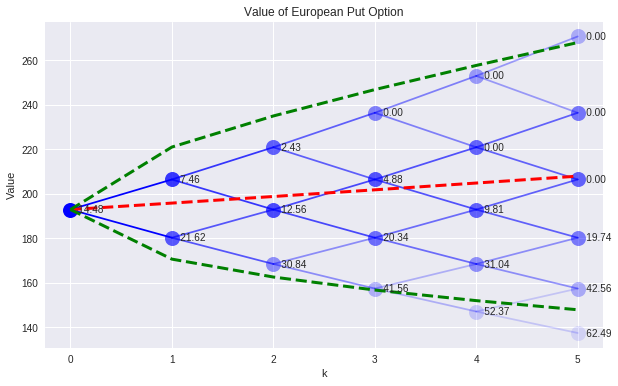

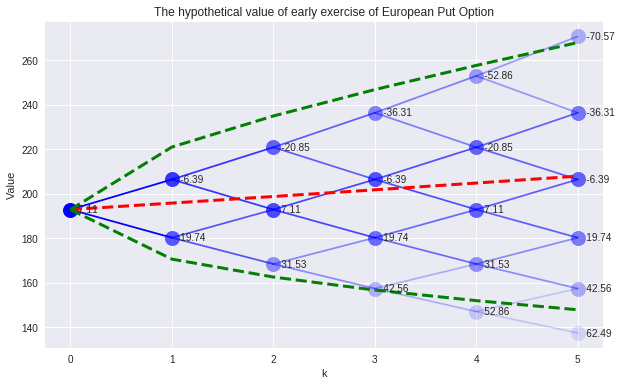

In [19]:
W = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        W[k,s] = m.W[k,s]()
        
SPdisplay(Sf,P,W)
plt.title('Value of European Put Option')

E = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        E[k,s] = K - Sf[k,s]
        
SPdisplay(Sf,P,E)
plt.title('The hypothetical value of early exercise of European Put Option')

We see several nodes where the value of exercising the option is worth more than the option itself. These would be opportunities for a risk-free profit. If such a circumstance arises, then 

1. buy the put option at price $P_{k,s}$
2. buy the asset at price $S^f_{k,s}$
3. exercise the option to sell at the strike price $K$

If $K > P_{k,s} + S^f_{k,s}$ then this deal offers a completely risk-free profit.

Text(0.5,1,'Arbitrage value for early exercise of a European Put Option')

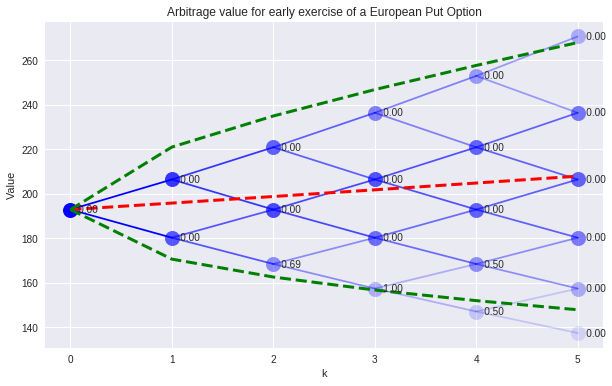

In [20]:
Arbitrage = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        Arbitrage[k,s] = max(0,(K - Sf[k,s] - m.W[k,s]()))
        
SPdisplay(Sf,P,Arbitrage)
plt.title('Arbitrage value for early exercise of a European Put Option')

## American put option

Compared to a European option, an American option provides an additional right of early exercise. The holder of the option an choose to exercise the option at any point prior to the expiration date.  This additional right can (but does not always add value under certain conditions.

The opportunity for early exerise adds some complexity to the calculation of value. In the optimization framework, the holder of an American put could always receive value by exercising the option if the market value of the option is less than the exercise value.  Thus the exercise value establishes a lower bound on the value of the option at all nodes (not just the terminal nodes)

$$P_{k,s} \geq K - S^f_{k,s}$$

This is demonstrated in the following cell.

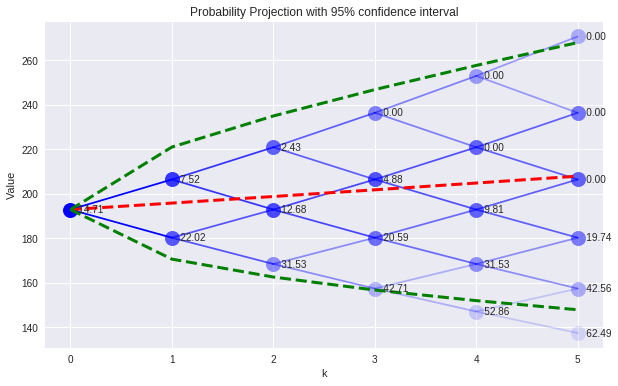

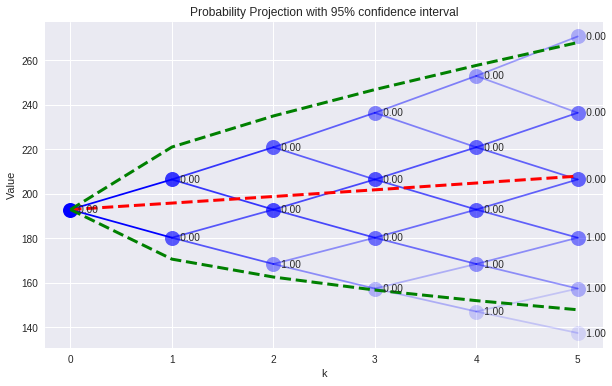

In [21]:
from pyomo.environ import *

# set of periods and states for each period
Periods = range(0,N+1)
States = range(0,N+1)

# future bond prices
B = [(1+r)**k for k in Periods]

m = ConcreteModel()

# model variables
m.W = Var(Periods,States,domain=Reals)
m.x = Var(Periods,States,domain=Reals)
m.y = Var(Periods,States,domain=Reals)

# objective
m.OBJ = Objective(expr = m.W[0,0], sense=minimize)

# constraint list
m.cons = ConstraintList()

for k in Periods:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s]*(1+r)**k)

for k in Periods:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] >= max(0,K - Sf[k,s]))

for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*Sf[k+1,s] + m.y[k,s]*B[k+1] >= m.W[k+1,s])
        m.cons.add(m.x[k,s]*Sf[k+1,s+1] + m.y[k,s]*B[k+1] >= m.W[k+1,s+1])

SolverFactory('glpk').solve(m)

W = {}
E = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        W[k,s] = m.W[k,s]()
        E[k,s] = np.abs(K-Sf[k,s] - m.W[k,s]()) < 0.01
        
SPdisplay(Sf,P,W)

SPdisplay(Sf,P,E)

<!--NAVIGATION-->
< [Financial Applications](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.00-Financial-Applications.ipynb) | [Contents](toc.ipynb) | [Historical Stock Data](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.02-Historical-Stock_-ata.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/08.01-Binomial-Model-for-Pricing-Options.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>